# Generate off-grid test stars

Generating a random set of stellar tracks to test the HBM on. This will be selected randomly assuing a mean helium enrichment law with some spread in Y. They will also assume a mean mixing-length-theory parameter with some spread. All other parameters will be chosen uniformly and randomly.

In [93]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Limits

The mass limits are 0.85 and 1.15 solar masses and the initial Z is truncated between 0.01 and 0.03 such that they are within the grid boundaries.

In [94]:
m_lim = (0.85, 1.15)
z_lim = (0.01, 0.03)
seed = 101

## Grid inputs

Randomly generate 100 grid inputs from the following. We draw the mass from,

$$M/M_\odot \sim \mathrm{Uniform}(0.85, 1.15)$$

We draw initial heavey-element fraction from,

$$Z_\mathrm{init} \sim \mathrm{Lognormal}(\mu=\ln(0.016), \sigma=0.3)$$

To truncate the initial Z within the limits above, we sample 100,000 from this distribution, then randomly choose 100 from elements of the array in the limits.

We parameterize initial helium fraction like so,

$$Y_P = 0.2467$$

$$\frac{\Delta Y}{\Delta Z} = 1.8$$

$$\mu_Y = Y_P + \frac{\Delta Y}{\Delta Z} Z_\mathrm{init}$$

$$\sigma_Y = 0.008$$

such that initial helium is drawn from,

$$Y_\mathrm{init} \sim \mathrm{Normal}(\mu=\mu_Y, \sigma=\sigma_Y)$$

Mixing-length theory parameter,

$$\alpha_\mathrm{mlt} \sim \mathrm{Normal}(\mu=2.0, \sigma=0.08)$$

In [95]:
def get_y(z, dydz, yp):
    return dydz * z + yp

In [96]:
np.random.seed(seed)
n = 100

# HYPERPARAMETERS
# Helium enrichment
dydz = 1.8
yp = 0.2467
sigma_y = 0.008

# Mixing-length-theory
mu_mlt = 2.0
sigma_mlt = 0.08

# Metallicity distribution
m_z = 0.016  # Lognormal median (scale) - roughly the initial solar metallicity
sigma_z = 0.3
zx_sun = 0.0181

# PARAMETERS
## Random uniform
mass = np.random.rand(n) * (m_lim[1] - m_lim[0]) + m_lim[0]
fov = np.zeros(n)
dif = np.ones(n, dtype=int)

# Draw initial z from a lognormal distribution
z_all = m_z * np.random.lognormal(sigma=sigma_z, size=100000)
z = np.random.choice(z_all[(z_all > z_lim[0]) & (z_all < z_lim[1])], size=n, replace=False)
# z = np.random.rand(n) * (z_lim[1] - z_lim[0]) + z_lim[0]

## Random normal
y = np.random.normal(loc=get_y(z, dydz, yp), scale=sigma_y, size=n)
mlt = np.random.normal(loc=mu_mlt, scale=sigma_mlt, size=n)

## Metallicity
zx = z / (1 - y - z)
feh = np.log10(zx) - np.log10(zx_sun)

## Plots

Plot the helium enrichment.

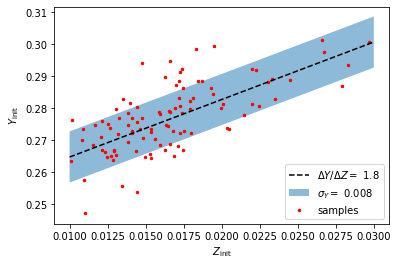

In [97]:
zz = np.linspace(*z_lim, 10)
yy = get_y(zz, dydz, yp)
plt.plot(zz, yy, '--k', label=r'$\Delta Y/\Delta Z =$ '+f'{dydz}')
plt.fill_between(zz, yy + sigma_y, yy - sigma_y, alpha=0.5, label=r'$\sigma_Y =$ '+f'{sigma_y}')

plt.scatter(z, y, s=6, c='r', label='samples')

plt.xlabel(r'$Z_\mathrm{init}$')
plt.ylabel(r'$Y_\mathrm{init}$')

plt.legend();

Plot the distributions of the input parameters.

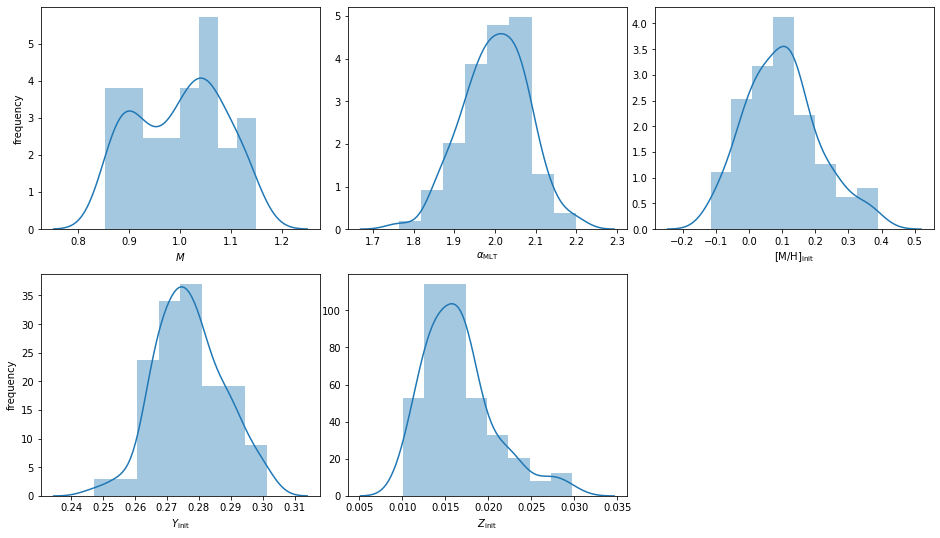

In [103]:
fig, axes = plt.subplots(2, 3, figsize=(16, 9), gridspec_kw={'wspace': 0.1})


sns.distplot(mass, ax=axes[0, 0], bins=8)  # , histtype='step')
axes[0, 0].set_xlabel(r'$M$')

sns.distplot(mlt, ax=axes[0, 1], bins=8)  # , histtype='step')
axes[0, 1].set_xlabel(r'$\alpha_\mathrm{MLT}$')

sns.distplot(feh, ax=axes[0, 2], bins=8)  # , histtype='step')
axes[0, 2].set_xlabel(r'$[\mathrm{M}/\mathrm{H}]_\mathrm{init}$')

sns.distplot(y, ax=axes[1, 0], bins=8) # , histtype='step')
axes[1, 0].set_xlabel(r'$Y_\mathrm{init}$')

sns.distplot(z, ax=axes[1, 1], bins=8)  # , histtype='step')
axes[1, 1].set_xlabel(r'$Z_\mathrm{init}$')

axes[1, 2].remove()

axes[0, 0].set_ylabel('frequency')
axes[1, 0].set_ylabel('frequency');

## Save inputs

In [104]:
d_param = dict(
    listm=mass,
    listY=y,
    listFeH=feh,
    listz=z,
    listalpha=mlt,
    listfov=fov,
    listdif=dif
)

In [105]:
df_param = round(pd.DataFrame(d_param), 5)
df_param.head(10)

,listm,listY,listFeH,listz,listalpha,listfov,listdif
0,1.00492,0.26815,0.12250,0.01715,1.87377,0.0,1
1,1.02120,0.27565,0.05092,0.01445,2.07644,0.0,1
2,0.85854,0.27288,0.13517,0.01753,1.84533,0.0,1
3,0.90146,0.28924,0.27204,0.02328,1.93942,0.0,1
4,1.05558,0.28007,0.12406,0.01693,2.06842,0.0,1
5,1.10017,0.28136,0.20132,0.02010,2.10936,0.0,1
6,0.94209,0.26475,0.06025,0.01498,1.89809,0.0,1
7,1.11808,0.26692,0.12923,0.01744,2.08093,0.0,1
8,1.06646,0.27371,0.20195,0.02034,1.98472,0.0,1
9,0.90698,0.29121,0.14036,0.01729,1.97220,0.0,1


In [114]:
df_param.to_csv('../data/tracks/test_grid/test_stars_inputs.csv', index=False)

## Save hyperparameters

We include the hyperparameters for Z even though these won't apply to the final model.

In [111]:
d_hyparam = dict(
    dydz=dydz,
    yp=yp,
    sigma_y=sigma_y,
    mu_mlt=mu_mlt,
    sigma_mlt=sigma_mlt,
    m_z=m_z,
    sigma_z=sigma_z
)

In [112]:
s_hyparam = pd.Series(d_hyparam)
s_hyparam

dydz         1.8000
yp           0.2467
sigma_y      0.0080
mu_mlt       2.0000
sigma_mlt    0.0800
m_z          0.0160
sigma_z      0.3000
dtype: float64

In [113]:
s_hyparam.to_csv('../data/tracks/test_grid/test_stars_hyperparams.csv', header=False)